<h1> <font color=steelblue>Constraining River Discharge Estimation Priors Using Reach-Scale Geomorphology</font></h1>
<br>
    Craig Brinkerhoff <br>
    Colin Gleason <br>
    Peirong Lin <br>
    Konstantinos Andreadis

<h3><font color=darkcyan> What? </font></h3>
<p>
BAM uses Bayesian inference to estimate river discharge and thus relies on prior distributions of certain variables. Also to be devolped for SADS and MetroMan
</p> <br>
<h5>
    So, can we produce better discharge estimates by constraining these priors by river type?
    <br><br>
    AND, how does our classification of American river geomorphology vary as a direct function of the hydrographic network used? i.e. are results fundamentally different if using coarser hydrographic networks, wherein many smaller rivers are functionally non-existent?
</h5>

<h3><font color=darkcyan> METHODS </font></h3>
<p>
&nbsp;&nbsp;&nbsp;&nbsp;1. Construction of classification spaces <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*K-means black box approach <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*PCA-informed supervised approach <br>
&nbsp;&nbsp;&nbsp;&nbsp;2. Map prior distributions onto classification spaces<br>
&nbsp;&nbsp;&nbsp;&nbsp;3. Construction of unsupervised system to assign remotely-sensed observations to the classification spaces (to contrast against 'expert' assinging of reaches to classes) <br>
</p>

<p> Note that throughout this analysis, the terms cluster, class, and group are used interchangeably. </p>

<h3><font color=darkcyan> MERIT Hydro </font></h3>

<p> This work is performed on a dataset of USGS field mesurements of channel hydraulics originally collected by Barber and Gleason (2018) joined to NHD, resulting in an expanded version of the dataset used in Brinkerhoff, et al. (2019, submitted)
    <br><br>
    Stream Order <br>
    Slope <br>
    Stream Drop <br>
    Maximum Grain Size Entrained (Henderson, 1966) <br>
    Shear Stress <br>
    Froude Number <br>
    Drainage Area <br>
    Unit Stream Power <br>
    Channel Shape <br>
    Channel Width <br>
    Channel Depth <br>
    Channel Velocity <br>
    Sinuosity <br>
    # rivers draining into reach ('topology')<br>
    <br><br>It must be stressed that these joined variables exist at the reach-scale, while the field measurements exist at the cross-section scale. Also, these results are only reflective of the hydrology/geomorphology of river reaches measured by the USGS, generally at streamagauges. IMPORTANT.</p>

<h3><font color=darkcyan> USGS NHD 2.1 </font></h3>

<p> This work is performed on a dataset of USGS field mesurements of channel hydraulics originally collected by Barber and Gleason (2018) joined to NHD, resulting in an expanded version of the dataset used in Brinkerhoff, et al. (2019, submitted)
    <br><br>
    Stream Order <br>
    Slope <br>
    Distance Downstream <br>
    Maximum Grain Size Entrained (Henderson, 1966) <br>
    Shear Stress <br>
    Froude Number <br>
    Drainage Area <br>
    Unit Stream Power <br>
    Channel Shape <br>
    Channel Width <br>
    Channel Depth <br>
    Channel Velocity <br>
    Reach Type (i.e. perennial, intermittent, lake/wetland/reservoir, canal, or connector).<br>
    Sinuosity (eventually)
    <br><br>It must be stressed that these joined variables exist at the reach-scale, while the field measurements exist at the cross-section scale. Also, these results are only reflective of the hydrology/geomorphology of river reaches measured by the USGS, generally at streamagauges. IMPORTANT.</p>

<h3><font color=darkcyan> Prior Distributions </font></h3>
<br>
    A0 is minimum observed cross-sectional channel area (Hagemann, et. al 2017) <br>
    n is Manning's n <br>
    b is width AHG b scaling exponent <br>
    Wc is congruent width from AMHG <br>
    Qc is congruent discharge from AMHG <br>
    Q is a prior on discharge for the reach <br>
    </p>

<h3><font color=darkcyan> Necessary preprocessing on NHD </font></h3>
<p> NHD for some reason has assigned many main stem or close-to-main stem reaches as artifical paths and not rivers.  Artifical paths are only supposed to be for throughflow lines in lakes/wetlands/reservoirs.
<br><br>
So, I identified reaches classed as 'ArtificalPath' that had no corresponding waterbodyID in the lakes dataset, assumed main stem reaches are perrenial, and reclassified those reaches as perrenial rivers.
<br><br> Canals and NHD's 'connectors' are listed as Artifical Channels.  'Connectors' are reaches the NHD had to add to make the network continuous in some places (i.e. trhough dams)
<br><br>
I am using the NHD's defintion of river intermittncy.  It's unclear how they designate perrenial/intermittent/ephemeral (no ephemeral reaches had measurements on them)
</p>

<h4> <font color=darkolivegreen> Initial Data Preperation, Wrangling, and Cleaning </font> </h4>

In [86]:
import pandas as pd
import os
import numpy as np
import scipy.stats.mstats as sp
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import math
from IPython.display import display, HTML
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import linear_model
from pandas.tools.plotting import parallel_coordinates
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from bokeh.plotting import figure, show, output_notebook
from bokeh.tile_providers import CARTODBPOSITRON
from ast import literal_eval

#set working directory here
os.chdir("C:\\Users\\cbrinkerhoff\\Box Sync\\Ongoing Projects\\geomorph_class\\")

#load in barber dataset
Hydroshortened = pd.read_csv('Barber_rivers.csv', low_memory=False, encoding='latin-1')

#MERIT Hydro
MERITshortened = pd.read_table('MERIT_Hydro_reaches2.txt', sep=',') #all reaches and atributes
MERITshortened['COMID'] = MERITshortened['COMID'].astype('int32')
MERITshortened = MERITshortened[MERITshortened['stationid'].str.startswith('USGS')]
MERITshortened['stationid'] = MERITshortened['stationid'].str[5:]
MERITshortened['stationid'] = pd.to_numeric(MERITshortened['stationid'])

MERITshortened = pd.merge(MERITshortened, Hydroshortened, left_on='stationid', right_on='site_no') #merge on usgs gauge ID

#NHD 2.1 flowlines and lakes
med_NHD = pd.read_csv('C:\\Users\\cbrinkerhoff\\Box Sync\\Ongoing Projects\\hydraulic_geometry_project\\working\\NHD_med_res.csv', low_memory=False, encoding='latin-1')
med_NHD_lakes = pd.read_csv('med_NHD_lakes.csv', low_memory=False, encoding='latin-1')

Hydroshortened = pd.merge(Hydroshortened, med_NHD[['SOURCE_FEA', 'SLOPE', 'StreamOrde', 'ArbolateSu', 'Measure', 'LENGTHKM', 'LatSite', 'LonSite', 'FTYPE', 'FCODE', 'DASqKm', 'Tidal', 'WBAREACOMI', 'TOTMA']],left_on='site_no', right_on='SOURCE_FEA')

#unitarea in file is catchment area for MERIT Hydro

<h2><font color=darkcyan> Analysis Using USGS NHD 2.1 </font></h2>

<h4><font color=darkolivegreen>Calculate mean hydraulic depth, fix channel material names, and some cleaning</font></h4>

In [2]:
Hydroshortened['chan_depth'] = Hydroshortened['chan_area']/Hydroshortened['chan_width']
Hydroshortened['chan_material'] = np.where(Hydroshortened['chan_material'] == 'silt', 'SILT', Hydroshortened['chan_material'])

#some cleaning (NA values and hydraulics below 0)
Hydroshortened = Hydroshortened[Hydroshortened['chan_width'] > 0]
Hydroshortened = Hydroshortened[Hydroshortened['chan_depth'] > 0]
Hydroshortened = Hydroshortened[Hydroshortened['chan_discharge'] > 0]
Hydroshortened = Hydroshortened[Hydroshortened['measured_rating_diff'] != 'Poor']
Hydroshortened = Hydroshortened[Hydroshortened['measured_rating_diff'] != 'POOR']

Hydroshortened = Hydroshortened[Hydroshortened['chan_width'].notnull()]
Hydroshortened = Hydroshortened[Hydroshortened['chan_depth'].notnull()]
Hydroshortened = Hydroshortened[Hydroshortened['chan_discharge'].notnull()]
Hydroshortened = Hydroshortened[Hydroshortened['chan_width'].notna()]
Hydroshortened = Hydroshortened[Hydroshortened['chan_depth'].notna()]
Hydroshortened = Hydroshortened[Hydroshortened['chan_discharge'].notna()]

<h4><font color=darkolivegreen>Calculate more variables and AHG</font></h4>

In [3]:
Hydroshortened['Rh'] = Hydroshortened['chan_area']/(Hydroshortened['chan_depth'] + (2*Hydroshortened['chan_width']))
Hydroshortened['n'] = ((Hydroshortened['Rh'])**(2/3)*Hydroshortened['SLOPE']**(1/2))/Hydroshortened['chan_velocity']
Hydroshortened['shearStress'] = 9.81*Hydroshortened['Rh']*Hydroshortened['SLOPE']
Hydroshortened['Fb'] = Hydroshortened['chan_velocity']/((Hydroshortened['chan_depth']*9.81)**(1/2))
Hydroshortened['minEntrain'] = 11*Hydroshortened['chan_depth']*Hydroshortened['SLOPE']

#A0
Hydroshortened = Hydroshortened.join(Hydroshortened.groupby('site_no')['chan_area'].agg(['min']), on='site_no')
Hydroshortened = Hydroshortened.rename(columns={"min": "A0"})

#AHG exp function
def regress(data, yvar, xvars):
    Y = np.log(data[yvar])
    X = np.log(data[xvars])
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    return result.params[0] #only get exp

#AHG int function
def regress2(data, yvar, xvars):
    Y = np.log(data[yvar])
    X = np.log(data[xvars])
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    return result.params[1] #only get int


groupSize = Hydroshortened.groupby('site_no').size().to_frame()
Hydroshortened = Hydroshortened.merge(groupSize, on='site_no')

b_temp = Hydroshortened.groupby('site_no').apply(regress, 'chan_width', ['chan_discharge']).to_frame()
a_temp = Hydroshortened.groupby('site_no').apply(regress2, 'chan_width', ['chan_discharge']).to_frame()
f_temp = Hydroshortened.groupby('site_no').apply(regress, 'chan_depth', ['chan_discharge']).to_frame()
c_temp = Hydroshortened.groupby('site_no').apply(regress2, 'chan_depth', ['chan_discharge']).to_frame()
m_temp = Hydroshortened.groupby('site_no').apply(regress, 'chan_velocity', ['chan_discharge']).to_frame()
k_temp = Hydroshortened.groupby('site_no').apply(regress2, 'chan_velocity', ['chan_discharge']).to_frame()

Hydroshortened =  pd.merge(Hydroshortened, b_temp, right_index=True, left_on='site_no')
Hydroshortened =  pd.merge(Hydroshortened, a_temp, right_index=True, left_on='site_no')
Hydroshortened = Hydroshortened.rename(columns={'0_y': "b"})
Hydroshortened = Hydroshortened.rename(columns={'0_x': "AHGsize"})
Hydroshortened = Hydroshortened.rename(columns={0: "loga"})

#Hydroshortened = Hydroshortened[Hydroshortened['AHGsize'] > 20] #need at least 20 at-a-station measurements to build AHG rating curve

Hydroshortened =  pd.merge(Hydroshortened, f_temp, right_index=True, left_on='site_no')
Hydroshortened =  pd.merge(Hydroshortened, m_temp, right_index=True, left_on='site_no')
Hydroshortened = Hydroshortened.rename(columns={'0_y': "m"})
Hydroshortened = Hydroshortened.rename(columns={'0_x': "f"})

Hydroshortened =  pd.merge(Hydroshortened, c_temp, right_index=True, left_on='site_no')
Hydroshortened =  pd.merge(Hydroshortened, k_temp, right_index=True, left_on='site_no')
Hydroshortened = Hydroshortened.rename(columns={'0_y': "logc"})
Hydroshortened = Hydroshortened.rename(columns={'0_x': "logk"})

Hydroshortened['r'] = Hydroshortened['f']/Hydroshortened['b']
Hydroshortened['unitPower'] = (998*9.8*Hydroshortened['chan_discharge']*Hydroshortened['SLOPE'])/Hydroshortened['chan_width']
Hydroshortened['DistDwnstrm'] = Hydroshortened['ArbolateSu']-((Hydroshortened['Measure']/100)*Hydroshortened['LENGTHKM'])
Hydroshortened['chan_material_index'] = np.where(Hydroshortened['chan_material'] == 'BLDR', 1,
                                                np.where(Hydroshortened['chan_material'] == 'GRVL', 2,
                                                        np.where(Hydroshortened['chan_material'] == 'SAND', 3,
                                                                np.where(Hydroshortened['chan_material'] == 'SILT', 4,
                                                                        np.where(Hydroshortened['chan_material'] == 'UNSP', 5,5)))))

Hydroshortened['FCODEnorm'] = np.where(Hydroshortened['FCODE'] == 33400, 1, #connectors or canals
                                                np.where(Hydroshortened['FCODE'] == 33600, 1, #connectors or canal
                                                        np.where(Hydroshortened['FCODE'] == 46003, 2, #intermittent river
                                                                np.where(Hydroshortened['FCODE'] == 46006, 3, #perienial river
                                                                        np.where(Hydroshortened['WBAREACOMI'].isin(med_NHD_lakes['COMID']), 4,3))))) #lake if also in lakes dataset, otherwise its a main stem river or tidal reach and can be reclassified as perrenial river (basically....)

Hydroshortened['FTYPE'] = np.where(Hydroshortened['FCODE'] == 33400, 'ArtificalChannel', #connector or canal
                                                np.where(Hydroshortened['FCODE'] == 33600, 'ArtificalChannel', #connector or canal
                                                        np.where(Hydroshortened['FCODE'] == 46003, 'IntermittentRiver', #intermittent river
                                                                np.where(Hydroshortened['FCODE'] == 46006, 'PerennialRiver', #perienial river
                                                                        np.where(Hydroshortened['WBAREACOMI'].isin(med_NHD_lakes['COMID']), 'Lake/Reservoir/Wetland','PerennialRiver')))))

<h4> <font color=darkolivegreen>Clean the dataset of impossible hydraulic geometry measurements and other impossible values (and get width AMHG) </font> </h4>

In [4]:
#convert needed units to metric
Hydroshortened['chan_width'] = Hydroshortened['chan_width']*0.305
Hydroshortened['chan_depth'] = Hydroshortened['chan_depth']*0.305
Hydroshortened['chan_velocity'] = Hydroshortened['chan_velocity']*0.305
Hydroshortened['chan_discharge'] = Hydroshortened['chan_discharge']*0.028

#filter impossible hydraulic geometry
Hydroshortened = Hydroshortened[Hydroshortened['b'] > 0]
Hydroshortened = Hydroshortened[Hydroshortened['b'] < 1]
Hydroshortened = Hydroshortened[Hydroshortened['f'] > 0]
Hydroshortened = Hydroshortened[Hydroshortened['f'] < 1]
Hydroshortened = Hydroshortened[Hydroshortened['m'] > 0]
Hydroshortened = Hydroshortened[Hydroshortened['m'] < 1]

#width AMHG
bySite = Hydroshortened.groupby('site_no').mean()
logWc_temp = Hydroshortened.groupby('river_name').apply(regress2, 'loga', ['b']).to_frame()
logQc_w_temp = Hydroshortened.groupby('river_name').apply(regress, 'loga', ['b']).to_frame()*-1

Hydroshortened =  pd.merge(Hydroshortened, logWc_temp, right_index=True, left_on='river_name')
Hydroshortened =  pd.merge(Hydroshortened, logQc_w_temp, right_index=True, left_on='river_name')
Hydroshortened = Hydroshortened.rename(columns={'0_y': "logQc_w"})
Hydroshortened = Hydroshortened.rename(columns={'0_x': "logWc"})

<h4> <font color=darkolivegreen>Normalize united metrics by observed Q </font> </h4>

In [45]:
#Hydroshortened['chan_width'] = Hydroshortened['chan_width']/Hydroshortened['chan_discharge']
#Hydroshortened['chan_depth'] = Hydroshortened['chan_depth']/Hydroshortened['chan_discharge']
#Hydroshortened['chan_velocity'] = Hydroshortened['chan_velocity']/Hydroshortened['chan_discharge']
#Hydroshortened['minEntrain'] = Hydroshortened['minEntrain']/Hydroshortened['chan_discharge']
#Hydroshortened['DistDwnstrm'] = Hydroshortened['DistDwnstrm']/Hydroshortened['chan_discharge']
#Hydroshortened['DASqKm'] = Hydroshortened['DASqKm']/Hydroshortened['chan_discharge']

<h4> <font color=darkolivegreen>Resulting Dataset</font> </h4>

In [44]:
print('\033[1m' + "# measurements:")
display(len(Hydroshortened.index))

print('\033[1m' + "# cross-sections:")
display(Hydroshortened.groupby('site_no').ngroups)

print('\033[1m' + "# rivers:")
display(Hydroshortened.groupby('river_name').ngroups)

# measurements:


372109

# cross-sections:


1444

# rivers:


190

In [5]:
#convert lat/long to web mercator function
def merc(Coords):
    Coordinates = literal_eval(Coords)
    lat = Coordinates[0]
    lon = Coordinates[1]
    
    r_major = 6378137.000
    x = r_major * math.radians(lon)
    scale = x/lon
    y = 180.0/math.pi * math.log(math.tan(math.pi/4.0 + 
        lat * (math.pi/180.0)/2.0)) * scale
    return (x, y)

#convert Hydroshortened lat/long to mercator
Hydroshortened['latlong'] = '(' + Hydroshortened["LatSite"].map(str) + ', ' + Hydroshortened["LonSite"].map(str) + ')'

Hydroshortened['long_merc'] = Hydroshortened['latlong'].apply(lambda x: merc(x)[0])
Hydroshortened['lat_merc'] = Hydroshortened['latlong'].apply(lambda x: merc(x)[1])

grouped = Hydroshortened.groupby('site_no').mean()

#plot basemap
p = figure(x_range=(-14026255, -7347086), y_range=(2999080, 7170156),
           x_axis_type="mercator", y_axis_type="mercator", title="Field-Measurement Locations", plot_width=900)
p.add_tile(CARTODBPOSITRON)

p.circle(x = grouped['long_merc'],
         y = grouped['lat_merc'],
        size=3,
        fill_color='darkgreen')

output_notebook()
show(p)

Loading BokehJS ...

<h4> <font color=darkolivegreen>Basic Exploratory Analysis</font> </h4>

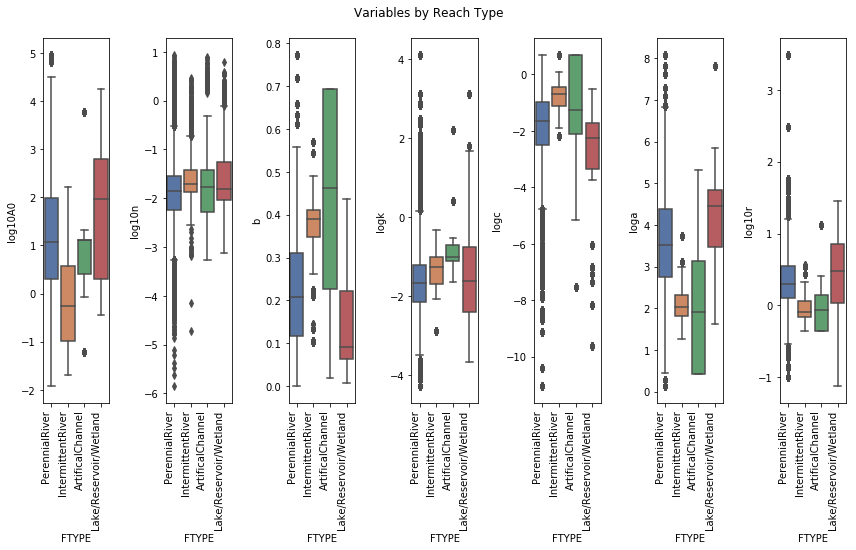

In [48]:
Hydroshortened['log10A0'] = np.log10(Hydroshortened['A0'])
Hydroshortened['log10r'] = np.log10(Hydroshortened['r'])
Hydroshortened['log10n'] = np.log10(Hydroshortened['n'])
Hydroshortened['log10unitPower'] = np.log10(Hydroshortened['unitPower'])

fig, axs = plt.subplots(ncols=7, figsize=(12, 8))
sns.boxplot(x='FTYPE', y='log10A0', data=Hydroshortened, palette='deep', ax=axs[0])
sns.boxplot(x='FTYPE', y='log10n', data=Hydroshortened, palette='deep', ax=axs[1])
sns.boxplot(x='FTYPE', y='b', data=Hydroshortened, palette='deep', ax=axs[2])
sns.boxplot(x='FTYPE', y='logk', data=Hydroshortened, palette='deep', ax=axs[3])
sns.boxplot(x='FTYPE', y='logc', data=Hydroshortened, palette='deep', ax=axs[4])
sns.boxplot(x='FTYPE', y='loga', data=Hydroshortened, palette='deep', ax=axs[5])
sns.boxplot(x='FTYPE', y='log10r', data=Hydroshortened, palette='deep', ax=axs[6])

fig.suptitle("Variables by Reach Type")
fig.autofmt_xdate(rotation=90)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

<h4><font color=darkolivegreen>Classification Space via KMeans: An Unsupervised Approach </font> </h4>
<p> K-Means is ran as an example of a wholy unsupervsied classification space.  I use the silhouette method to assess the ideal number of classes.  It is a measure of how close a point is to points in the other clusters in the predictor space, where values closer to 1 indicate the sample is far away from neighboring clusters.</p>

In [49]:
#Silhouette Method
#n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
#result = []
#for i in n_clusters:
#    kmeans_var_silhouette = Hydroshortened[['chan_width','SLOPE', 'StreamOrde','DistDwnstrm', 'chan_material_index', 'chan_depth', 'chan_velocity', 'unitPower', 'r', 'FCODEnorm', 'DASqKm', 'Fb', 'shearStress', 'minEntrain', 'TOTMA']]
#    kmeans_silhouette = KMeans(n_clusters= i, random_state=0).fit(kmeans_var_silhouette)
#    labels = kmeans_silhouette.labels_
#    score = metrics.silhouette_score(kmeans_var_silhouette, labels, metric='euclidean')
#    result.append(score)

#plot results
#line = sns.lineplot(x = n_clusters, y=result)
#line.set_title("Silhouette  Analysis")
#line.set(xlabel='# Groups', ylabel='Silhouette Score')
#line

<p> While the best silhouette score was for 2 clusters, this was deemed too small for this analysis and so it was decided that the number of clusters to use was 3-6 ( the same satisfyingly high silhouette score). </p>
<p> KMeans is now run with 4 clusters (silhouette score of <b>______</b>): </p>
<br>
<h4><font color=darkolivegreen>Classify via Kmeans</font> </h4>

In [50]:
kmeans_var = Hydroshortened[['chan_width','SLOPE', 'StreamOrde','DistDwnstrm', 'chan_depth', 'chan_velocity', 'unitPower', 'r', 'FCODEnorm', 'DASqKm', 'Fb', 'shearStress', 'minEntrain', 'TOTMA']]
kmeans = KMeans(n_clusters=10, random_state=0).fit(kmeans_var)
y_pred = kmeans.predict(kmeans_var) #predicted values

<h4> <font color=darkolivegreen>Classification Space via PCAs: a Supervised Approach </font></h4>
<p> Principal component analysis (PCA) was used to identify the 'main axes of variation' in the dataset.  This was done somewhat subjectively, weighting the percent variance explained by each PC and each PC's respective top-weighted metrics.  Then, names were assigned to each PC to reflect these 'main axes of variation'
</p>

In [48]:
#run PCA
features = ['chan_width', 'n', 'SLOPE', 'StreamOrde','DistDwnstrm', 'FCODEnorm', 'chan_depth', 'chan_velocity', 'unitPower', 'r', 'DASqKm', 'Fb', 'shearStress', 'minEntrain', 'TOTMA']
x = Hydroshortened.loc[:, features].values # Separating out the features
y = Hydroshortened.loc[:,['site_no']].values # Separating out the target
x = StandardScaler().fit_transform(x) # normalizing the features

pca = PCA(n_components=5) #ran using 5 PCs
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = pca.components_
             , columns = ['chan_width', 'n', 'SLOPE', 'StreamOrde','DistDwnstrm', 'FCODEnorm', 'chan_depth', 'chan_velocity', 'unitPower', 'r', 'DASqKm', 'Fb', 'shearStress', 'minEntrain', 'TOTMA'])

,chan_width,n,SLOPE,StreamOrde,DistDwnstrm,FCODEnorm,chan_depth,chan_velocity,unitPower,r,DASqKm,Fb,shearStress,minEntrain,TOTMA
0,0.010821,-0.009333,0.450782,0.018984,0.026838,-0.064945,0.036014,0.004557,0.494921,-0.001557,0.027063,0.004557,0.521163,0.522111,0.007844
1,0.387765,-0.126478,-0.050094,0.455773,0.550380,0.063822,0.111889,0.083320,-0.010016,-0.006999,0.537790,0.083320,-0.016927,-0.014823,0.011602
2,-0.046695,-0.041940,0.003620,-0.052218,-0.072906,-0.005960,-0.011746,0.700947,-0.000207,0.002339,-0.071349,0.700947,-0.002674,-0.002980,0.008101
3,0.131621,0.540059,-0.037257,0.030854,-0.002752,-0.039954,0.253689,0.026545,0.013547,-0.108889,-0.034871,0.026545,0.001369,0.014168,-0.779643
4,0.054512,-0.263286,-0.011029,-0.000184,-0.126688,0.608820,0.340553,-0.012135,0.040220,0.618257,-0.098264,-0.012135,0.007923,0.026177,-0.174188


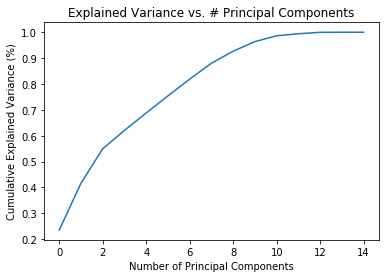

In [50]:
#Plot explained variance by each principal component 'PC'
pca = PCA().fit(x)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('Explained Variance vs. # Principal Components')

#Present table of relative weighings of each predictor variable on each resulting PC
principalDf
#pca.explained_variance_ratio_

<p>
    5 PCs were ultimately selected for analysis as they explain ~75% of variance in the dataset and are not too many to make developing intuitive understandings of the dataset difficult, particularly with only 12 initial variables before dimensionality reduction.
</p>
<p>
   The top weighted metrics for PC1 are unit power, slope, shear stress, and minimum entrained grain size.  For PC2 they are stream order, distance downstream, and drainage area.  For PC3 it is velocity and froude number,  for PC4 it is tidal influence, and PC5 is channel shape.
    <br><br>
    <b>The main axes of geomorphic variation across these rivers have thus been termed 'Sediment Transport', 'Longitunidal Location', 'Flow State', 'Tidal Influence', and 'Channel Shape'.</b>
</p>
<br>
<p>
    I then use a 'geomorphic index' which is just a sum of the top 5 PC values for each measurement.  This is purposefully not weighted by the relative importance of each PC (i.e. they're all weighted equally).  Then, classes are determined by breaking the measurements along the deciles for the distribution
</p>

In [51]:
#get quantiles for PCs and 'top-weighted' variables to assist in supervised classification
tertiles = [0.33, 0.66]
quantiles= [0.20, 0.40, 0.60, 0.80]
deciles = [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90]

#add PC values to hydroshortened
Hydroshortened['PC1'] = principalComponents[:,0]
Hydroshortened['PC2'] = principalComponents[:,1]
Hydroshortened['PC3'] = principalComponents[:,2]
Hydroshortened['PC4'] = principalComponents[:,3]
Hydroshortened['PC5'] = principalComponents[:,4]

PC1 = np.quantile(Hydroshortened['PC1'], tertiles)
PC2 = np.quantile(Hydroshortened['PC2'], tertiles)

Hydroshortened['geomorphIndex'] = (Hydroshortened['PC1']*0.22)+(Hydroshortened['PC2']*0.20)+(Hydroshortened['PC3']*0.15)+(Hydroshortened['PC4']*0.08)+(Hydroshortened['PC5']*0.08)
geomorphIndex = np.quantile(Hydroshortened['geomorphIndex'], deciles)

#clusters created using 50th percentile of PC1 and 50th percentile of PC2, subjectively determined.
Hydroshortened['clusterPCA'] = np.where((Hydroshortened['PC1']< PC1[0]) & (Hydroshortened['PC2'] < PC2[0]), 'Low order, low power', 
                                        np.where((Hydroshortened['PC1'] > PC1[0]) & (Hydroshortened['PC1'] < PC1[1])&(Hydroshortened['PC2'] < PC2[0]), 'Medium order, low power', 
                                                np.where((Hydroshortened['PC1']< PC1[0]) & (Hydroshortened['PC2'] > PC2[0]) & (Hydroshortened['PC2'] < PC2[1]), 'Low order, medium power',
                                                        np.where((Hydroshortened['PC1']< PC1[1]) & (Hydroshortened['PC2'] < PC2[1]), 'Medium Order, medium power',
                                                                 np.where((Hydroshortened['PC1'] > PC1[1]) & (Hydroshortened['PC2'] < PC2[0]), 'High order, low power',
                                                                          np.where((Hydroshortened['PC1']> PC1[1]) & (Hydroshortened['PC2'] < PC2[1]), 'High order, medium power',
                                                                                  np.where((Hydroshortened['PC1']> PC1[1]) & (Hydroshortened['PC2'] > PC2[1]), 'High order, high power',
                                                                                          np.where((Hydroshortened['PC1']< PC1[0]) & (Hydroshortened['PC2'] > PC2[1]), 'Low order, high power','Medium order, high power'))))))))

Hydroshortened['clusterGeomorphIndex'] = np.where(Hydroshortened['geomorphIndex']<geomorphIndex[0], '1', 
                                               np.where(Hydroshortened['geomorphIndex']<geomorphIndex[1], '2', 
                                                       np.where(Hydroshortened['geomorphIndex']<geomorphIndex[2], '3', 
                                                               np.where(Hydroshortened['geomorphIndex']<geomorphIndex[3], '4',
                                                                        np.where(Hydroshortened['geomorphIndex']<geomorphIndex[4], '5', 
                                                                                 np.where(Hydroshortened['geomorphIndex']<geomorphIndex[5], '6', 
                                                                                          np.where(Hydroshortened['geomorphIndex']<geomorphIndex[6], '7',
                                                                                                   np.where(Hydroshortened['geomorphIndex']<geomorphIndex[7], '8',
                                                                                                           np.where(Hydroshortened['geomorphIndex']<geomorphIndex[8], '9', '10')))))))))

<h4> <font color=darkolivegreen>Plotting KMeans and PCA results </font></h4>
<p> All combos of PCs are plotted against one another, colored by Kmeans group.  PDFs of PC values are also included, segregated by Kmeans group. </p>

In [54]:
#temp = pd.DataFrame(data=principalComponents)
#y_predSeries = pd.Series(y_pred)
#y_predDF = y_predSeries.to_frame(name='Group')

#plotDF = temp.merge(y_predDF, how='inner', right_index=True, left_index=True)
#plot = sns.pairplot(plotDF, hue='Group', vars=[0,1,2, 3], palette = 'deep')
#plot.fig.suptitle("Principal Component Axes for HYDRoSWOT w/ KMeans Groups")

In [55]:
#PCAplot = sns.pairplot(Hydroshortened, hue='clusterPCA', vars=['PC1', 'PC2', 'PC3'], palette = 'deep')
#PCAplot.fig.suptitle("Principal Component Axes for HYDRoSWOT w/ PCA-informed Classes")

<h4> <font color=darkolivegreen>Map prior distributions onto class spaces for KMeans classes</font></h4>

[(-1, 2)]

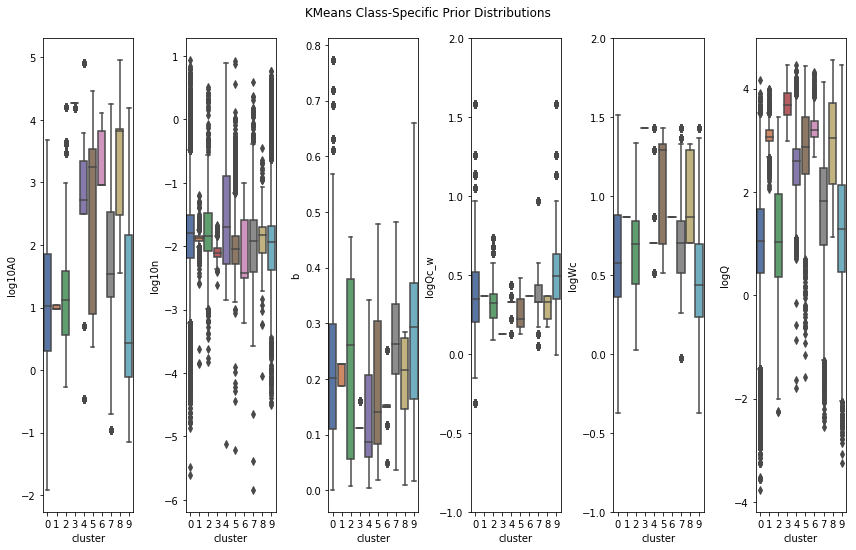

In [56]:
Hydroshortened['cluster'] = kmeans.labels_
Hydroshortened['logQ'] = np.log10(Hydroshortened['chan_discharge'])

fig, axs = plt.subplots(ncols=6, figsize=(12, 8))
sns.boxplot(x="cluster", y='log10A0', data=Hydroshortened, palette='deep', ax=axs[0])
sns.boxplot(x="cluster", y='log10n', data=Hydroshortened, palette='deep', ax=axs[1])
sns.boxplot(x="cluster", y='b', data=Hydroshortened, palette='deep', ax=axs[2])
sns.boxplot(x="cluster", y='logQc_w', data=Hydroshortened, palette='deep', ax=axs[3])
sns.boxplot(x="cluster", y='logWc', data=Hydroshortened, palette='deep', ax=axs[4])
sns.boxplot(x="cluster", y='logQ', data=Hydroshortened, palette='deep', ax=axs[5])

fig.suptitle("KMeans Class-Specific Prior Distributions")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
axs[4].set(ylim=(-1, 2))
axs[3].set(ylim=(-1, 2))

<h4> <font color=darkolivegreen>Map prior distributions onto class spaces for PCA-based Classes</font></h4>

ValueError: Could not interpret input 'log10A0'

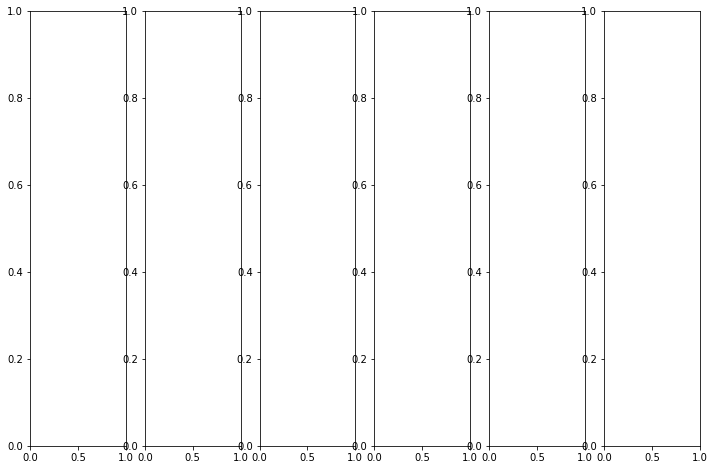

In [52]:
fig, axs = plt.subplots(ncols=6, figsize=(12, 8))
sns.boxplot(x="clusterGeomorphIndex", y='log10A0', data=Hydroshortened, palette='deep', ax=axs[0], order=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
sns.boxplot(x="clusterGeomorphIndex", y='log10n', data=Hydroshortened, palette='deep', ax=axs[1], order=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
sns.boxplot(x="clusterGeomorphIndex", y='b', data=Hydroshortened, palette='deep', ax=axs[2], order=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
sns.boxplot(x="clusterGeomorphIndex", y='logQc_w', data=Hydroshortened, palette='deep', ax=axs[3], order=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
sns.boxplot(x="clusterGeomorphIndex", y='logWc', data=Hydroshortened, palette='deep', ax=axs[4], order=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
sns.boxplot(x="clusterGeomorphIndex", y='logQ', data=Hydroshortened, palette='deep', ax=axs[5], order=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])

fig.suptitle("Geomorphic Index Class-Specific Prior Distributions")
fig.autofmt_xdate(rotation=90)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
axs[4].set(ylim=(-0.2, 1.4))
axs[3].set(ylim=(0, 1))
axs[1].set(ylim=(-4, -0.5))

<h4> <font color=darkolivegreen>Map AHG Parameter distributions onto class spaces for PCA-based Classes for global estimation</font></h4>

[(-4, -0.5)]

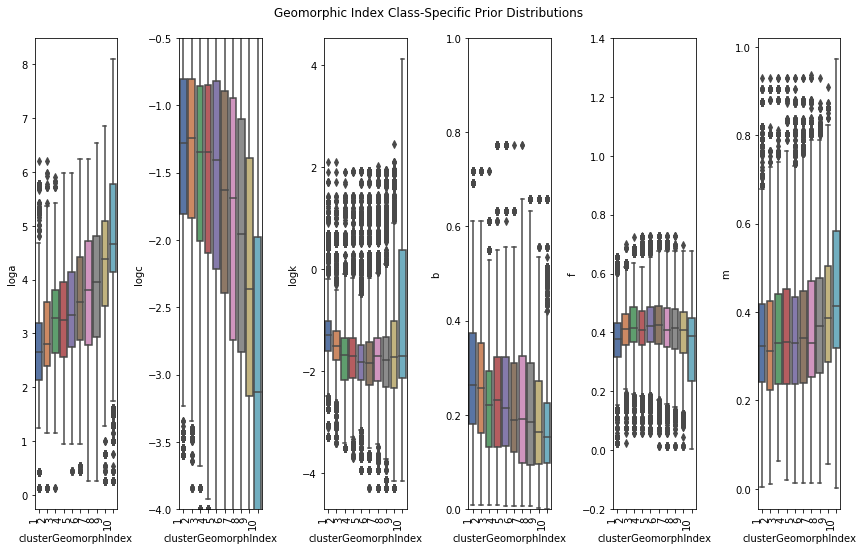

In [53]:
fig, axs = plt.subplots(ncols=6, figsize=(12, 8))
sns.boxplot(x="clusterGeomorphIndex", y='loga', data=Hydroshortened, palette='deep', ax=axs[0], order=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
sns.boxplot(x="clusterGeomorphIndex", y='logc', data=Hydroshortened, palette='deep', ax=axs[1], order=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
sns.boxplot(x="clusterGeomorphIndex", y='logk', data=Hydroshortened, palette='deep', ax=axs[2], order=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
sns.boxplot(x="clusterGeomorphIndex", y='b', data=Hydroshortened, palette='deep', ax=axs[3], order=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
sns.boxplot(x="clusterGeomorphIndex", y='f', data=Hydroshortened, palette='deep', ax=axs[4], order=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
sns.boxplot(x="clusterGeomorphIndex", y='m', data=Hydroshortened, palette='deep', ax=axs[5], order=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])

fig.suptitle("Geomorphic Index Class-Specific Prior Distributions")
fig.autofmt_xdate(rotation=90)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
axs[4].set(ylim=(-0.2, 1.4))
axs[3].set(ylim=(0, 1))
axs[1].set(ylim=(-4, -0.5))

Current notes OUT OF DATE: <br>
    2) channel material includes many where it was unspecified.  What to do, because I'd love to include frictional resistance here BASICALLY CAN'T REALLY USE I'D SAY SINCE MOST ARE UNSEPCIFIED<br>
        -to address this I've currently added Henderson (1965)'s 'minimum grain size entrained' as a variable
    <br>
    3) add sinuosity <br>
    4) still not sure how to treat reach type because they need to be reclassified 1-5 in some manner that makes sense when interpreting PC values

<h4> <font color=darkolivegreen>Building Unsupervised Decision Forest for Remotely Determining K-Means Class</font></h4>
<p> The unsupervised classification space built using KMeans is great, however many of its input variables are not remotely sensible or obtainable from the hydrography being used to estimate river discharge.  So, a simple desicion tree is built using the variables which are remotely accessible to determine which group distribution to use for a given reach.  These predictor variables are stream width, slope, and stream order.  Because they are also used to build the classification space, the predictive accuracy of this classification forest will be extremely high. </p>

In [58]:
variables = ['chan_width','SLOPE', 'StreamOrde', 'cluster']
temp = Hydroshortened.loc[:, variables].values # Separating out the remotely-sensible variables
X_trn, X_tst, y_trn, y_tst = train_test_split(temp[:,0:3], temp[:,3], test_size=0.2, random_state=42) #80% training, 20% testing

clf = RandomForestClassifier(n_estimators=100, random_state=0) #only 100 desicion trees
clf.fit(X_trn, y_trn)
predictions = clf.predict(X_tst)

print('\033[1m' + "Realtive Predictor Variable Imortances:")
display(clf.feature_importances_)
print('\033[1m' + "Confusion Matrix:")
display(confusion_matrix(y_tst,predictions))
print('\033[1m' + "Accuracy Score:")
display(accuracy_score(y_tst,predictions))

Realtive Predictor Variable Imortances:


array([0.20392228, 0.36929284, 0.42678489])

Confusion Matrix:


array([[53956,     0,    23,     0,     0,     0,     0,    24,     0,
          667],
       [    0,   926,     0,     0,     0,     0,     0,     0,     0,
            0],
       [   84,     0,   654,     0,     0,     2,     0,     4,     0,
           10],
       [    0,     0,     0,   704,     0,     0,     0,     0,     0,
            0],
       [    0,     0,     0,     0,   507,     0,     7,     0,    17,
            0],
       [    0,     0,     1,     0,     0,  1394,     0,    55,     0,
           15],
       [    0,     0,     0,     0,     2,     0,   550,     0,     6,
            0],
       [  271,     0,     5,     0,     0,    77,     0,  2224,     0,
          186],
       [    0,     0,     0,     0,    11,     0,     8,     0,   415,
            0],
       [ 1691,     0,     1,     0,     0,    31,     0,    83,     0,
         9811]], dtype=int64)

Accuracy Score:


0.9559135739431889

<h4> <font color=darkolivegreen>Building Unsupervised Decision Forest for Remotely Determining PCA-based Geomorph Index Class</font></h4>
<p> A similar approach to above is trained for the PCA-based supervised classification space.  Based on manually set PC-thresholds, classes assignd to every gage measurement and then these classes are drained on a deiscion forest </p>

In [59]:
#do the above
variablesPCA = ['chan_width','SLOPE', 'StreamOrde', 'DASqKm', 'DistDwnstrm', 'clusterGeomorphIndex'] #this time, use PCA clusters
tempPCA = Hydroshortened.loc[:, variablesPCA].values # Separating out the remotely-sensible variables
X_trnPCA, X_tstPCA, y_trnPCA, y_tstPCA = train_test_split(tempPCA[:,0:5], tempPCA[:,5], test_size=0.2, random_state=42) #80% training, 20% testing

clfPCA = RandomForestClassifier(n_estimators=100, random_state=0) #only 100 desicion trees
clfPCA.fit(X_trnPCA, y_trnPCA)
predictionsPCA = clfPCA.predict(X_tstPCA)

print('\033[1m' + "Realtive Predictor Variable Importances:")
display(clfPCA.feature_importances_)
print('\033[1m' + "Confusion Matrix:")
display(confusion_matrix(y_tstPCA,predictionsPCA))
print('\033[1m' + "Accuracy Score:")
display(accuracy_score(y_tstPCA,predictionsPCA))

Realtive Predictor Variable Importances:


array([0.23258372, 0.19707662, 0.04948654, 0.25696313, 0.26388998])

Confusion Matrix:


array([[6933,    0,  273,   10,    1,    1,    0,    0,    0,    1],
       [   3, 6999,    4,    3,    5,    2,    5,    7,   27,  281],
       [ 267,    1, 6702,  555,    3,    7,    1,    1,    0,    2],
       [  10,    0,  510, 6245,  584,   12,    0,    4,    0,    3],
       [   2,    3,   29,  669, 6187,  540,   24,    7,    2,    1],
       [   1,    1,    5,   21,  641, 6285,  658,   25,    5,    4],
       [   1,    0,    2,    6,   42,  704, 5991,  621,   33,   11],
       [   4,    9,   10,    2,   12,   39,  632, 6342,  449,   24],
       [   1,   23,    1,    1,    1,    5,   59,  598, 6328,  409],
       [   2,  260,    1,    0,    0,    2,    5,   26,  504, 6690]],
      dtype=int64)

Accuracy Score:


0.8693934589234367

<h2><font color=darkcyan> Analysis Using MERIT Hydro </font></h2>

In [87]:
MERITshortened['chan_depth'] = MERITshortened['chan_area']/MERITshortened['chan_width']
MERITshortened['chan_material'] = np.where(MERITshortened['chan_material'] == 'silt', 'SILT', MERITshortened['chan_material'])

#some cleaning (NA values and hydraulics below 0)
MERITshortened = MERITshortened[MERITshortened['chan_width'] > 0]
MERITshortened = MERITshortened[MERITshortened['chan_depth'] > 0]
MERITshortened = MERITshortened[MERITshortened['chan_discharge'] > 0]
MERITshortened = MERITshortened[MERITshortened['measured_rating_diff'] != 'Poor']
MERITshortened = MERITshortened[MERITshortened['measured_rating_diff'] != 'POOR']

MERITshortened = MERITshortened[MERITshortened['chan_width'].notnull()]
MERITshortened = MERITshortened[MERITshortened['chan_depth'].notnull()]
MERITshortened = MERITshortened[MERITshortened['chan_discharge'].notnull()]
MERITshortened = MERITshortened[MERITshortened['chan_width'].notna()]
MERITshortened = MERITshortened[MERITshortened['chan_depth'].notna()]
MERITshortened = MERITshortened[MERITshortened['chan_discharge'].notna()]

In [88]:
MERITshortened['Rh'] = MERITshortened['chan_area']/(MERITshortened['chan_depth'] + (2*MERITshortened['chan_width']))
MERITshortened['n'] = ((MERITshortened['Rh'])**(2/3)*MERITshortened['slope']**(1/2))/MERITshortened['chan_velocity']
MERITshortened['shearStress'] = 9.81*MERITshortened['Rh']*MERITshortened['slope']
MERITshortened['Fb'] = MERITshortened['chan_velocity']/((MERITshortened['chan_depth']*9.81)**(1/2))
MERITshortened['minEntrain'] = 11*MERITshortened['chan_depth']*MERITshortened['slope']

#A0
MERITshortened = MERITshortened.join(MERITshortened.groupby('site_no')['chan_area'].agg(['min']), on='site_no')
MERITshortened = MERITshortened.rename(columns={"min": "A0"})

#AHG exp function
def regress(data, yvar, xvars):
    Y = np.log(data[yvar])
    X = np.log(data[xvars])
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    return result.params[0] #only get exp

#AHG int function
def regress2(data, yvar, xvars):
    Y = np.log(data[yvar])
    X = np.log(data[xvars])
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    return result.params[1] #only get int

#AHG r2 function
def regress3(data, yvar, xvars):
    Y = np.log(data[yvar])
    X = np.log(data[xvars])
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    return result.rsquared #only get r2


groupSize = MERITshortened.groupby('site_no').size().to_frame()
MERITshortened = MERITshortened.merge(groupSize, on='site_no')

b_temp = MERITshortened.groupby('site_no').apply(regress, 'chan_width', ['chan_discharge']).to_frame()
a_temp = MERITshortened.groupby('site_no').apply(regress2, 'chan_width', ['chan_discharge']).to_frame()
f_temp = MERITshortened.groupby('site_no').apply(regress, 'chan_depth', ['chan_discharge']).to_frame()
c_temp = MERITshortened.groupby('site_no').apply(regress2, 'chan_depth', ['chan_discharge']).to_frame()
m_temp = MERITshortened.groupby('site_no').apply(regress, 'chan_velocity', ['chan_discharge']).to_frame()
k_temp = MERITshortened.groupby('site_no').apply(regress2, 'chan_velocity', ['chan_discharge']).to_frame()

MERITshortened =  pd.merge(MERITshortened, b_temp, right_index=True, left_on='site_no')
MERITshortened =  pd.merge(MERITshortened, a_temp, right_index=True, left_on='site_no')
MERITshortened = MERITshortened.rename(columns={'0_y': "b"})
MERITshortened = MERITshortened.rename(columns={'0_x': "AHGsize"})
MERITshortened = MERITshortened.rename(columns={0: "loga"})

#Hydroshortened = Hydroshortened[Hydroshortened['AHGsize'] > 20] #need at least 20 at-a-station measurements to build AHG rating curve

MERITshortened =  pd.merge(MERITshortened, f_temp, right_index=True, left_on='site_no')
MERITshortened =  pd.merge(MERITshortened, m_temp, right_index=True, left_on='site_no')
MERITshortened = MERITshortened.rename(columns={'0_y': "m"})
MERITshortened = MERITshortened.rename(columns={'0_x': "f"})

MERITshortened =  pd.merge(MERITshortened, c_temp, right_index=True, left_on='site_no')
MERITshortened =  pd.merge(MERITshortened, k_temp, right_index=True, left_on='site_no')
MERITshortened = MERITshortened.rename(columns={'0_y': "logc"})
MERITshortened = MERITshortened.rename(columns={'0_x': "logk"})

MERITshortened['r'] = MERITshortened['f']/MERITshortened['b']
MERITshortened['unitPower'] = (998*9.8*MERITshortened['chan_discharge']*MERITshortened['slope'])/MERITshortened['chan_width']
MERITshortened['chan_material_index'] = np.where(MERITshortened['chan_material'] == 'BLDR', 1,
                                                np.where(MERITshortened['chan_material'] == 'GRVL', 2,
                                                        np.where(MERITshortened['chan_material'] == 'SAND', 3,
                                                                np.where(MERITshortened['chan_material'] == 'SILT', 4,
                                                                        np.where(MERITshortened['chan_material'] == 'UNSP', 5,5)))))

In [89]:
#convert needed units to metric
MERITshortened['chan_width'] = MERITshortened['chan_width']*0.305
MERITshortened['chan_depth'] = MERITshortened['chan_depth']*0.305
MERITshortened['chan_velocity'] = MERITshortened['chan_velocity']*0.305
MERITshortened['chan_discharge'] = MERITshortened['chan_discharge']*0.028

MERITshortened['HRT'] = (MERITshortened['chan_velocity']*0.001)/MERITshortened['lengthkm'] #m/s to km/s

#filter impossible hydraulic geometry
MERITshortened = MERITshortened[MERITshortened['b'] > 0]
MERITshortened = MERITshortened[MERITshortened['b'] < 1]
MERITshortened = MERITshortened[MERITshortened['f'] > 0]
MERITshortened = MERITshortened[MERITshortened['f'] < 1]
MERITshortened = MERITshortened[MERITshortened['m'] > 0]
MERITshortened = MERITshortened[MERITshortened['m'] < 1]

#width AMHG
bySite = MERITshortened.groupby('site_no').mean()
logWc_temp = MERITshortened.groupby('river_name').apply(regress2, 'loga', ['b']).to_frame()
logQc_w_temp = MERITshortened.groupby('river_name').apply(regress, 'loga', ['b']).to_frame()*-1

MERITshortened =  pd.merge(MERITshortened, logWc_temp, right_index=True, left_on='river_name')
MERITshortened =  pd.merge(MERITshortened, logQc_w_temp, right_index=True, left_on='river_name')
MERITshortened = MERITshortened.rename(columns={'0_y': "logQc_w"})
MERITshortened = MERITshortened.rename(columns={'0_x': "logWc"})

In [33]:
#MERITshortened = MERITshortened[MERITshortened['unitarea']>0]

print('\033[1m' + "# measurements:")
display(len(MERITshortened.index))

print('\033[1m' + "# cross-sections:")
display(MERITshortened.groupby('site_no').ngroups)

print('\033[1m' + "# rivers:")
display(MERITshortened.groupby('river_name').ngroups)

# measurements:


259844

# cross-sections:


889

# rivers:


176

In [34]:
#convert lat/long to web mercator function
def merc(Coords):
    Coordinates = literal_eval(Coords)
    lat = Coordinates[0]
    lon = Coordinates[1]
    
    r_major = 6378137.000
    x = r_major * math.radians(lon)
    scale = x/lon
    y = 180.0/math.pi * math.log(math.tan(math.pi/4.0 + 
        lat * (math.pi/180.0)/2.0)) * scale
    return (x, y)

#convert MERITshortened lat/long to mercator
MERITshortened['latlong'] = '(' + MERITshortened["lat"].map(str) + ', ' + MERITshortened["lon"].map(str) + ')'

MERITshortened['long_merc'] = MERITshortened['latlong'].apply(lambda x: merc(x)[0])
MERITshortened['lat_merc'] = MERITshortened['latlong'].apply(lambda x: merc(x)[1])

grouped = MERITshortened.groupby('site_no').mean()

#plot basemap
p = figure(x_range=(-14026255, -7347086), y_range=(2999080, 7170156),
           x_axis_type="mercator", y_axis_type="mercator", title="Field-Measurement Locations", plot_width=900)
p.add_tile(CARTODBPOSITRON)

p.circle(x = grouped['long_merc'],
         y = grouped['lat_merc'],
        size=3,
        fill_color='darkgreen')

output_notebook()
show(p)

Loading BokehJS ...

In [90]:
kmeans_var = MERITshortened[['chan_width', 'n', 'slope', 'order_', 'chan_depth', 'chan_velocity', 'unitPower', 'r', 'unitarea', 'Fb', 'shearStress', 'minEntrain', 'sinuosity', 'strmDrop_t', 'maxup', 'HRT']]
kmeans = KMeans(n_clusters=10, random_state=0).fit(kmeans_var)
y_pred = kmeans.predict(kmeans_var) #predicted values

In [91]:
#run PCA
features = ['chan_width', 'n', 'slope', 'order_', 'chan_depth', 'chan_velocity', 'unitPower', 'r', 'unitarea', 'Fb', 'shearStress', 'minEntrain', 'sinuosity', 'strmDrop_t', 'maxup', 'HRT']
x = MERITshortened.loc[:, features].values # Separating out the features
y = MERITshortened.loc[:,['site_no']].values # Separating out the target
x = StandardScaler().fit_transform(x) # normalizing the features

pca = PCA(n_components=5) #ran using 5 PCs
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = pca.components_
             , columns = ['chan_width', 'n', 'slope', 'order_', 'chan_depth', 'chan_velocity', 'unitPower', 'r', 'unitarea', 'Fb', 'shearStress', 'minEntrain', 'sinuosity', 'strmDrop_t', 'maxup', 'HRT'])

,chan_width,n,slope,order_,chan_depth,chan_velocity,unitPower,r,unitarea,Fb,shearStress,minEntrain,sinuosity,strmDrop_t,maxup,HRT
0,0.004800,-0.056539,0.420052,-0.078493,0.200236,0.060659,0.433421,0.008727,0.048609,0.060659,0.464780,0.479200,-0.109884,0.338100,-0.047052,0.046649
1,0.030967,-0.042763,-0.063430,0.046152,-0.001566,0.600065,-0.018195,-0.002337,-0.039858,0.600065,-0.038829,-0.037380,-0.008263,-0.066284,0.027691,0.510727
2,0.288633,-0.069631,-0.288718,0.441848,0.379461,-0.056487,0.261991,-0.011966,-0.324981,-0.056487,0.018476,0.225188,-0.114528,-0.381670,0.312474,-0.031743
3,-0.020328,0.016175,-0.313846,-0.308997,0.436510,0.019369,0.219248,0.093300,0.317686,0.019369,-0.151856,0.164408,0.427229,-0.215045,-0.420949,-0.017301
4,-0.216399,0.341514,-0.022182,-0.386195,0.033163,-0.020542,0.027809,-0.093351,-0.519884,-0.020542,0.010238,0.057139,-0.451827,-0.271530,-0.346300,0.063409


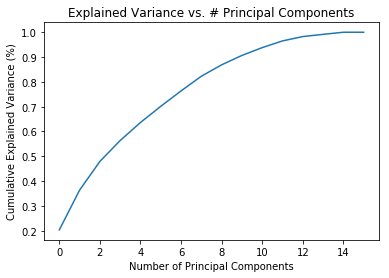

In [92]:
#Plot explained variance by each principal component 'PC'
pca = PCA().fit(x)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('Explained Variance vs. # Principal Components')

#Present table of relative weighings of each predictor variable on each resulting PC
principalDf
#pca.explained_variance_ratio_

In [137]:
#get quantiles for PCs and 'top-weighted' variables to assist in supervised classification
tertiles = [0.33, 0.66]
quantiles= [0.20, 0.40, 0.60, 0.80]
deciles = [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90]
hexadeciles = [0.0625, 0.1250, 0.1875, 0.25, 0.3125, 0.375, 0.4375, 0.50, 0.5625, 0.625, 0.6875, 0.75, 0.8125, 0.875, 0.9375]

#add PC values to hydroshortened
MERITshortened['PC1'] = principalComponents[:,0]
MERITshortened['PC2'] = principalComponents[:,1]
MERITshortened['PC3'] = principalComponents[:,2]
MERITshortened['PC4'] = principalComponents[:,3]
MERITshortened['PC5'] = principalComponents[:,4]

MERITshortened['geomorphIndex'] = (MERITshortened['PC1'])+(MERITshortened['PC2'])+(MERITshortened['PC3'])+(MERITshortened['PC4'])+(MERITshortened['PC5'])
geomorphIndex = np.quantile(MERITshortened['geomorphIndex'], hexadeciles)

MERITshortened['clusterGeomorphIndex'] = np.where(MERITshortened['geomorphIndex']<geomorphIndex[0], '1', 
                                               np.where(MERITshortened['geomorphIndex']<geomorphIndex[1], '2', 
                                                       np.where(MERITshortened['geomorphIndex']<geomorphIndex[2], '3', 
                                                               np.where(MERITshortened['geomorphIndex']<geomorphIndex[3], '4',
                                                                        np.where(MERITshortened['geomorphIndex']<geomorphIndex[4], '5', 
                                                                                 np.where(MERITshortened['geomorphIndex']<geomorphIndex[5], '6', 
                                                                                          np.where(MERITshortened['geomorphIndex']<geomorphIndex[6], '7',
                                                                                                   np.where(MERITshortened['geomorphIndex']<geomorphIndex[7], '8',
                                                                                                           np.where(MERITshortened['geomorphIndex']<geomorphIndex[8], '9',
                                                                                                                   np.where(MERITshortened['geomorphIndex']<geomorphIndex[9], '10',
                                                                                                                           np.where(MERITshortened['geomorphIndex']<geomorphIndex[10], '11',
                                                                                                                                   np.where(MERITshortened['geomorphIndex']<geomorphIndex[11], '12',
                                                                                                                                           np.where(MERITshortened['geomorphIndex']<geomorphIndex[2], '13',
                                                                                                                                                   np.where(MERITshortened['geomorphIndex']<geomorphIndex[13], '14',
                                                                                                                                                   np.where(MERITshortened['geomorphIndex']<geomorphIndex[4], '15','16')))))))))))))))

[(-1, 2)]

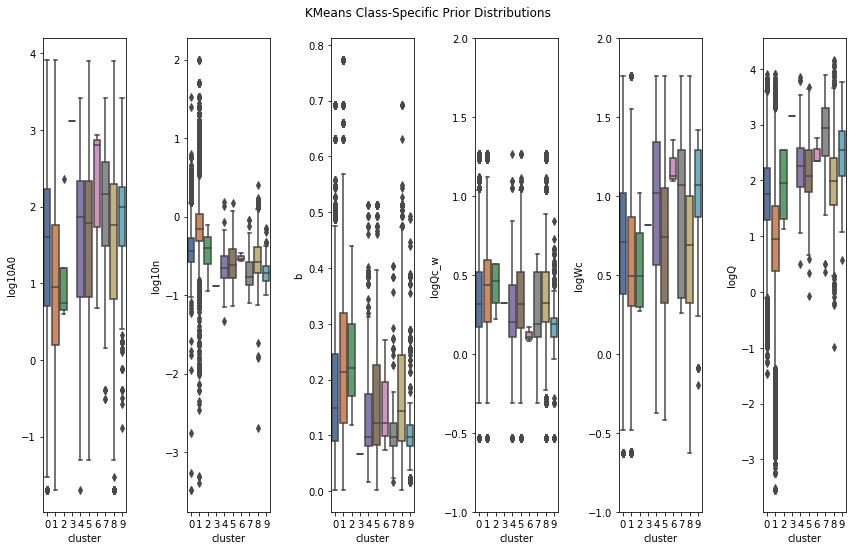

In [94]:
#plot kmeans classes
MERITshortened['cluster'] = kmeans.labels_
MERITshortened['logQ'] = np.log10(MERITshortened['chan_discharge'])
MERITshortened['log10A0'] = np.log10(MERITshortened['A0'])
MERITshortened['log10n'] = np.log10(MERITshortened['n'])

fig, axs = plt.subplots(ncols=6, figsize=(12, 8))
sns.boxplot(x="cluster", y='log10A0', data=MERITshortened, palette='deep', ax=axs[0])
sns.boxplot(x="cluster", y='log10n', data=MERITshortened, palette='deep', ax=axs[1])
sns.boxplot(x="cluster", y='b', data=MERITshortened, palette='deep', ax=axs[2])
sns.boxplot(x="cluster", y='logQc_w', data=MERITshortened, palette='deep', ax=axs[3])
sns.boxplot(x="cluster", y='logWc', data=MERITshortened, palette='deep', ax=axs[4])
sns.boxplot(x="cluster", y='logQ', data=MERITshortened, palette='deep', ax=axs[5])

fig.suptitle("KMeans Class-Specific Prior Distributions")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
axs[4].set(ylim=(-1, 2))
axs[3].set(ylim=(-1, 2))

[(-1, 1)]

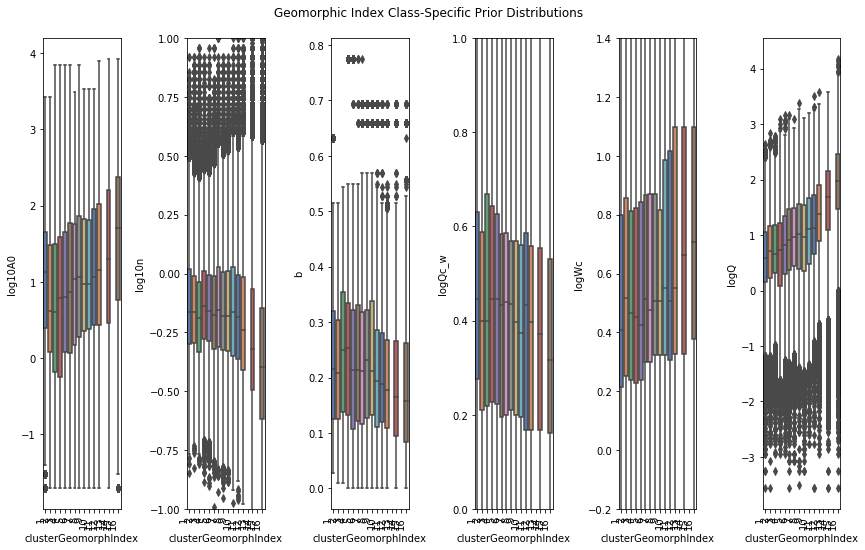

In [138]:
#plot index classes
fig, axs = plt.subplots(ncols=6, figsize=(12, 8))
sns.boxplot(x="clusterGeomorphIndex", y='log10A0', data=MERITshortened, palette='deep', ax=axs[0], order=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16'])
sns.boxplot(x="clusterGeomorphIndex", y='log10n', data=MERITshortened, palette='deep', ax=axs[1], order=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16'])
sns.boxplot(x="clusterGeomorphIndex", y='b', data=MERITshortened, palette='deep', ax=axs[2], order=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16'])
sns.boxplot(x="clusterGeomorphIndex", y='logQc_w', data=MERITshortened, palette='deep', ax=axs[3], order=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16'])
sns.boxplot(x="clusterGeomorphIndex", y='logWc', data=MERITshortened, palette='deep', ax=axs[4], order=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16'])
sns.boxplot(x="clusterGeomorphIndex", y='logQ', data=MERITshortened, palette='deep', ax=axs[5], order=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16'])

fig.suptitle("Geomorphic Index Class-Specific Prior Distributions")
fig.autofmt_xdate(rotation=90)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
axs[4].set(ylim=(-0.2, 1.4))
axs[3].set(ylim=(0, 1))
axs[1].set(ylim=(-1, 1))

[(-4, -0.5)]

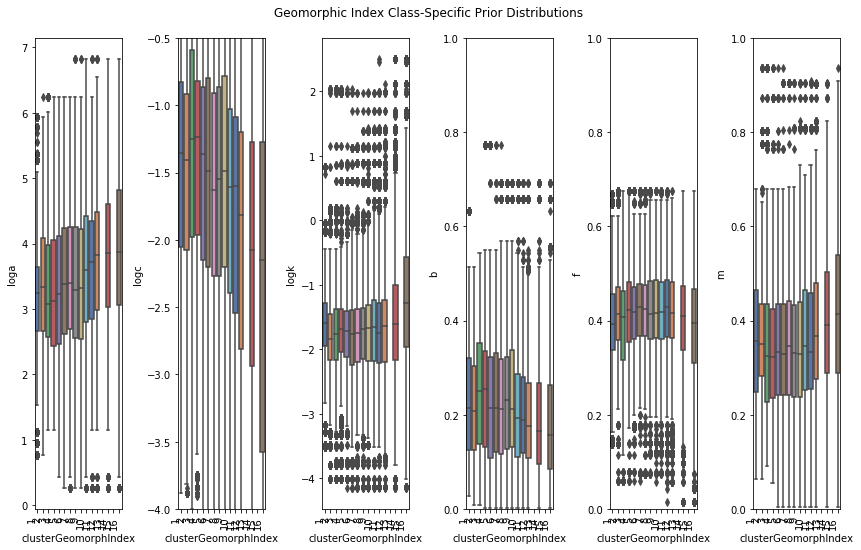

In [107]:
#plot AHG parameters per index class
fig, axs = plt.subplots(ncols=6, figsize=(12, 8))
sns.boxplot(x="clusterGeomorphIndex", y='loga', data=MERITshortened, palette='deep', ax=axs[0], order=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16'])
sns.boxplot(x="clusterGeomorphIndex", y='logc', data=MERITshortened, palette='deep', ax=axs[1], order=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16'])
sns.boxplot(x="clusterGeomorphIndex", y='logk', data=MERITshortened, palette='deep', ax=axs[2], order=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16'])
sns.boxplot(x="clusterGeomorphIndex", y='b', data=MERITshortened, palette='deep', ax=axs[3], order=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16'])
sns.boxplot(x="clusterGeomorphIndex", y='f', data=MERITshortened, palette='deep', ax=axs[4], order=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16'])
sns.boxplot(x="clusterGeomorphIndex", y='m', data=MERITshortened, palette='deep', ax=axs[5], order=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16'])

fig.suptitle("Geomorphic Index Class-Specific Prior Distributions")
fig.autofmt_xdate(rotation=90)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
axs[4].set(ylim=(0, 1))
axs[3].set(ylim=(0, 1))
axs[5].set(ylim=(0,1))
axs[1].set(ylim=(-4, -0.5))

In [142]:
s_temp = MERITshortened.groupby('clusterGeomorphIndex').apply(regress, 'chan_depth', ['chan_discharge']).to_frame()
u_temp = MERITshortened.groupby('clusterGeomorphIndex').apply(regress2, 'chan_depth', ['chan_discharge']).to_frame()
r2_temp = MERITshortened.groupby('clusterGeomorphIndex').apply(regress3, 'chan_width', ['chan_discharge']).to_frame()

r2_temp
#Then, the idea is to globally model width and depth using these trained functions to each river class,
#and then back V out b/c the v~Q model performs horrendously

,0
clusterGeomorphIndex,
1,0.813379
10,0.731354
11,0.706138
12,0.705850
14,0.706099
16,0.608784
2,0.753992
3,0.743563
4,0.809040


In [76]:
#assign AHG parameters to each geomorphic class
#MERITshortened['global_ahg_a'] = MERITshortened.join(np.exp(MERITshortened.groupby('clusterGeomorphIndex')['loga'].mean()), on='clusterGeomorphIndex', rsuffix='_r')
#MERITshortened['global_ahg_c'] = MERITshortened.join(np.exp(MERITshortened.groupby('clusterGeomorphIndex')['logc'].mean()), on='clusterGeomorphIndex', rsuffix='_r')
#MERITshortened['global_ahg_k'] = MERITshortened.join(np.exp(MERITshortened.groupby('clusterGeomorphIndex')['logk'].mean()), on='clusterGeomorphIndex', rsuffix='_r')

#MERITshortened['global_ahg_b'] = MERITshortened.join(MERITshortened.groupby('clusterGeomorphIndex')['b'].mean(), on='clusterGeomorphIndex', rsuffix='_r')
#MERITshortened['global_ahg_f'] = MERITshortened.join(MERITshortened.groupby('clusterGeomorphIndex')['f'].mean(), on='clusterGeomorphIndex', rsuffix='_r')
#MERITshortened['global_ahg_m'] = MERITshortened.join(MERITshortened.groupby('clusterGeomorphIndex')['m'].mean(), on='clusterGeomorphIndex', rsuffix='_r')

#MERITshortened['global_depth'] = MERITshortened['global_ahg_c']/(MERITshortened['global_ahg_a']**(MERITshortened['global_ahg_f']/MERITshortened['global_ahg_b']))*MERITshortened['chan_width']**(MERITshortened['global_ahg_f']/MERITshortened['global_ahg_b'])
MERITshortened['log10_chan_depth'] = MERITshortened['chan_depth']
MERITshortened['log10_global_depth'] = np.log10(MERITshortened['global_depth'])
sns.scatterplot(x="log10_chan_depth", y='log10_global_depth', data=MERITshortened)


AttributeError: 'float' object has no attribute 'log10'

<p>Current Problems and Notes:
    <br><br>
    1) There are some gauges with unitarea null, and they appear to be mostly PNW on the map... I think this is an error in my join and I should figure it out instead of just filtering these from the dataset. <B>SOLVED</B>
    <br><br>
    2) Might want to remove my rough HRT... seems to lower % variance explained and just add on to the velocity/Fb PC
    <br><br>
    3) Should I really be classifying the fluvial index along quantiles? It means every class is the exact same size (~16,000 measurements)... I need to try a wholly supervised binning method, as opposed to semi-supervised setting of quantiles
    <br><br>
    4) Ultimately, the umber of classes chosen is going to be a big question.  Need to some how assessa trade-off between class size and constraining the PDFs handed to BAM (also, smaller classes seems to help the global depth model a bit...)
    </p>